# Практическое задание 4
## TensorFlow

<ol>
    <li>Попробовать улучшить точность распознования образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложить анализ с описанием того, что улучшает работу нейронной сети и что ухудшает.
    </li>
    <li>Описать также в анализе какие необоходимо внести изменения  в получившуюся у вас нейронную сеть если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.
    </li>
</ol>

### Решение
1. Пробовал много разных подходов.
В итоге модель с урока улучшилась засчет добавления ещё одной группы слоев CNN-CCN-MaxPooling со 128 ядрами в свертках.

В аугментации исользовал горизонтальные отражения, небольшое зуммирование и повороты изображений.

Ещё помогло изменение функции активации на полносвязном слое на ELU.

В качестве оптимизаторов пробовал Adam и RMSProp с параметрами по умолчанию.<br>
Лучше себя показал Adam.<br>
Финальная точность на тестовой выборке 78.21%.

Основные ошибки - это патаница кошек с собаками, птиц с самолетами и лошадей с оленями. Но они действительно похожи на таких маленьких изображениях.

2. Для других датасетов необходимо конечно в первую очередь изменить число выходных слоев в зависимости от числа классов, а также входную размерность, в зависимости от размера изображений и каналов.

Теперь об изменениях в скрытых слоях.

1) Для датасета с бОльшими изображениями, думаю, стоит ещё добавить группы слоев CNN-CNN-MAxPooling с ещё большим числом ядер, как, например в VGG сетях, которые как раз создавались для ImageNet. Для Cifar-100 нужно нечто среднее.

2) Для датасета с бОльшим числом классов, также стоит увеличить число нейронов и, возможно, слоев в полносвязной части сети.

3) И в зависимости от числа тренировочных изображений регулировать число настраиваемых параметров, чтобы модель не переобучалась и не недообучалась. Если все-таки решили оставить параметров сильно больше, чем тренировочных изображений, то стоит добавить Dropout слои.

В общем, я бы сделал, сложность сетей по нарастающей для датасетов в следующем порядке: MNIST -> CIFAR-10 -> CIFAR-100 -> IMAGENET-1000

In [1]:
,import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
MY_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Computer_vision/Models'

### Загрузка и подготовка датасета CIFAR10

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.astype(np.float32) / 255
test_x = test_x.astype(np.float32) / 255

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

In [5]:
print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


### Визуализация датасета CIFAR10

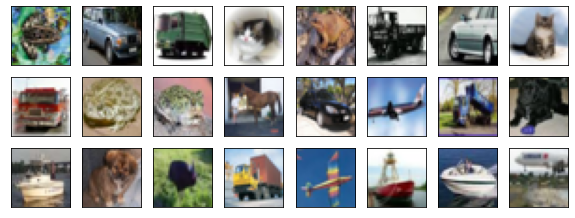

In [6]:
some_samples = train_x[200:224, ...]

fig = plt.figure(figsize=(10, 5))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j, ...])
    plt.xticks([]), plt.yticks([])
plt.show()

### Список классов

In [7]:
labels = ['Самолет', 'Автомобиль', 'Птица', 'Кот', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

y_to_label = {y: label for y, label in enumerate(labels)}

### Создание модели

In [8]:
NUM_EPOCHS = 30
BATCH_SIZE = 64
INP_SHAPE = train_x.shape[1:]

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=INP_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

### Обучение

In [9]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(
        MY_DRIVE_PATH, 
        'cifar10_wghts_loss{val_loss:.2f}_acc{val_accuracy:.2f}.hdf5'), 
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy')

history = model.fit(
    train_x,
    train_y,
    epochs=NUM_EPOCHS,
    validation_data=(test_x, test_y),
    batch_size=BATCH_SIZE,
    callbacks=[callback])

Epoch 1/30
782/782 [==============================] - 6s 7ms/step - loss: 1.6831 - accuracy: 0.3831 - val_loss: 1.4735 - val_accuracy: 0.4747
Epoch 2/30
782/782 [==============================] - 5s 7ms/step - loss: 1.3417 - accuracy: 0.5172 - val_loss: 1.1562 - val_accuracy: 0.5816
Epoch 3/30
782/782 [==============================] - 5s 7ms/step - loss: 1.1807 - accuracy: 0.5801 - val_loss: 1.1887 - val_accuracy: 0.5915
Epoch 4/30
782/782 [==============================] - 5s 7ms/step - loss: 1.0677 - accuracy: 0.6214 - val_loss: 0.9656 - val_accuracy: 0.6615
Epoch 5/30
782/782 [==============================] - 5s 7ms/step - loss: 0.9887 - accuracy: 0.6511 - val_loss: 0.8748 - val_accuracy: 0.6932
Epoch 6/30
782/782 [==============================] - 5s 7ms/step - loss: 0.9268 - accuracy: 0.6735 - val_loss: 0.8249 - val_accuracy: 0.7158
Epoch 7/30
782/782 [==============================] - 5s 7ms/step - loss: 0.8794 - accuracy: 0.6906 - val_loss: 0.8171 - val_accuracy: 0.7128
Epoch 

### Результат обучения

Оставим веса от лучшей модели

In [14]:
model.load_weights(os.path.join(MY_DRIVE_PATH, 'cifar10_wghts_loss0.67_acc0.78.hdf5'))

In [15]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 2ms/step - loss: 0.6678 - accuracy: 0.7821


[0.6678040027618408, 0.7821000218391418]

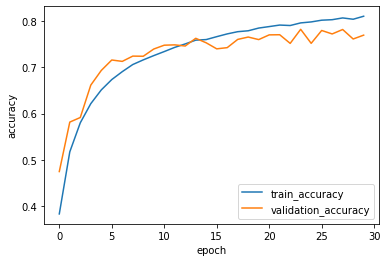

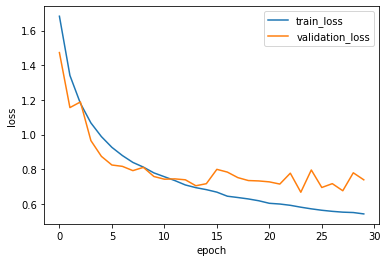

In [11]:
for metrics in ['accuracy', 'loss']:
    plt.plot(history.history[metrics])
    plt.plot(history.history[f'val_{metrics}'])
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend([f'train_{metrics}', f'validation_{metrics}'], loc='best')
    plt.show()

### Функция для отображения результата предсказания

In [16]:
def test_item(sample):

    preds = model.predict([img]).flatten()
    index = np.argmax(preds)
    pred = y_to_label[index]
    
    fig = plt.figure(figsize=(6,2))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(y_to_label[ans]))

### Запуск предсказания для пяти случайных изображений

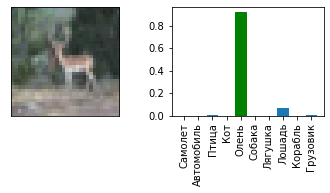

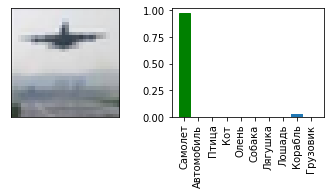

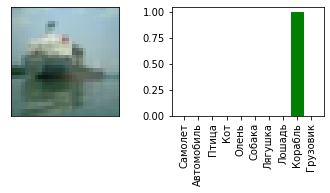

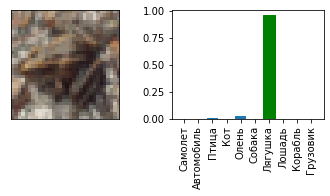

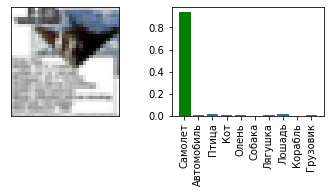

In [69]:
for _ in range(5):
    idx = np.random.choice(test_x.shape[0])
    img = test_x[idx].reshape((1, *test_x[idx].shape))

    preds = model.predict([img]).flatten()
    index = np.argmax(preds)
    pred = y_to_label[index]

    fig = plt.figure(figsize=(6,2))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img[0])
    plt.xticks([]), plt.yticks([])

    ax2 = fig.add_subplot(1, 2, 2)
    mybar = ax2.bar(range(10), preds)
    plt.xticks(range(10), labels, rotation='vertical')
    color = 'g' if index == test_y[idx] else 'r'
    mybar[index].set_color(color)
    plt.show()